# NMA Gigantic Mouses fMRI Project

## 0. Load modules

In [1]:
from collections import OrderedDict
import glob
from google.colab import drive
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import scipy.io as sio
import seaborn as sns
from scipy.stats import spearmanr
from sklearn import linear_model
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
import torch
from torch.autograd import Variable as V
import torch.nn as nn
from torchvision import transforms as trn
import torchvision.models as models
from tqdm import tqdm
import urllib

## 1. Load fMRI RDMs by Cichy et al. (2014)

The data were downloaded from [https://osf.io/7vpyh/](https://osf.io/7vpyh/).

In [2]:
#@title Define helper function for reading MATLAB files { display-mode: "form" }
def loadmat(matfile):
    """Function to load .mat files.
    Parameters
    ----------
    matfile : str
        path to `matfile` containing fMRI data for a given trial.
    Returns
    -------
    dict
        dictionary containing data in key 'vol' for a given trial.
    """

    try:
        f = h5py.File(matfile)
    except (IOError, OSError):
        return sio.loadmat(matfile)
    else:
        return {name: np.transpose(f.get(name)) for name in f.keys()}

In [3]:
# Load fMRI RDMs from mounted Google Drive
drive.mount('/content/drive')
data_dir = Path('/content/drive/Shareddrives/NMA-Computational Neuroscience/data')
fmri_file = data_dir / '92_Image_Set/target_fmri.mat'
fmri_rdms = loadmat(fmri_file)

# Extract RDMs for our two regions of interest
evc_rdms = fmri_rdms['EVC_RDMs']
it_rdms = fmri_rdms['IT_RDMs']
print(evc_rdms.shape)
print(it_rdms.shape)

Mounted at /content/drive
(15, 92, 92)
(15, 92, 92)


In [74]:
#@title Define helper function for plotting RDMs { display-mode: "form" }
def average_rdms(rdms):
    """Averages an array of RDMs over the first dimension(s)
    Parameters
    ----------
    rdms : np.array
        RDMs of shape (... x images x images) with 1 - correlation as elements.
    Returns
    -------
    rdm : np.array
        RDMs (1 - corr) as array of shape (images x images)
    """

    # Average about all dimensions except the last two
    average_dims = tuple(range(rdms.ndim - 2))
    rdm = rdms.mean(axis=average_dims)

    return rdm


def layer_labels(n_layers):
    """Create x axis labels with layer numbers
    Parameters
    ----------
    n_layers : int
        Number of layers in the DNN.
    Returns
    -------
    labels : list
        List of labels for each layer, e.g. 'Layer #1'
    """
  
    labels = [f'Layer #{x + 1}' for x in range(n_layers)]
    return(labels)


def plot_rdms(rdms, labels=None, title=None, file=None, vmax=1.5):
    """Plots an array of RDMs, averaged over additional dimensions if necessary
    Parameters
    ----------
    rdms : np.array
        RDMs of shape (... x images x images) with 1 - correlation as elements.
    """

    # Prepare figure
    n_rdms = rdms.shape[0]
    n_cols = n_rdms + 2
    gridspec_kw = {'width_ratios': [3] * n_rdms + [0.3, 0.4]}
    figsize = (sum(gridspec_kw['width_ratios']), 3)
    fig, ax = plt.subplots(nrows=1, ncols=n_cols, figsize=figsize,
                           gridspec_kw=gridspec_kw)
    ax[-2].set_axis_off()

    # Plot RDMs, averaged across additional dimensions if necessary
    vmin, vmax = (0, vmax)
    for ix in range(n_rdms):
      rdm = average_rdms(rdms[ix])
      rdm[np.triu_indices(rdm.shape[0], 1)] = np.nan
      im = ax[ix].imshow(rdm, cmap='Spectral_r', vmin=vmin, vmax=vmax,
                         interpolation='nearest')
      ax[ix].xaxis.set_ticks([])
      ax[ix].yaxis.set_ticks([])
      ax[ix].set_xlabel('Stimuli')
      if ix == 0:
        ax[ix].set_ylabel('Stimuli')
      if labels is not None:
        ax[ix].text(x=0.95, y=0.9, s=labels[ix], horizontalalignment='right',
                    transform=ax[ix].transAxes)
    
    # Add colorbar
    cbar = fig.colorbar(im, cax=ax[-1])
    cbar.ax.get_yaxis().labelpad = 2
    cbar.ax.set_ylabel('$1-$ correlation', rotation=90)
    cbar.set_ticks(np.linspace(vmin, vmax, num=4))
    ax[-1].yaxis.set_ticks_position('left')
    ax[-1].yaxis.set_label_position('left')

    # Add title if requested
    if title is not None:
      fig.suptitle(title)
      plt.subplots_adjust(top=0.9)
    
    # Save if requested
    if file is not None:
      fig.savefig(file, dpi=1000)


help(plot_rdms)

Help on function plot_rdms in module __main__:

plot_rdms(rdms, labels=None, title=None, file=None, vmax=1.5)
    Plots an array of RDMs, averaged over additional dimensions if necessary
    Parameters
    ----------
    rdms : np.array
        RDMs of shape (... x images x images) with 1 - correlation as elements.



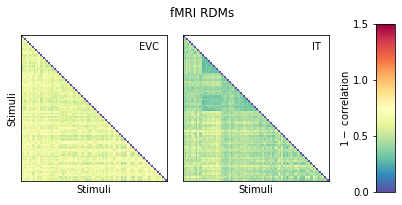

In [75]:
# Prepare figures directory
figures_dir = data_dir / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

# Plot fMRI RDMs, averaged across subjects
fmri_rdms_avg = np.array([evc_rdms, it_rdms])
plot_rdms(fmri_rdms_avg, labels=['EVC', 'IT'], title='fMRI RDMs',
          file=figures_dir / 'rdms_fmri.svg')

## 2. Computing RDMs for layers of different DNNs

### 2.1 Helper functions

In [7]:
#@title Define functions to extract activations
def load_alexnet(model_checkpoints):
    """This function initializes an Alexnet and load
    its weights from a pretrained model. Since we redefined model in a different
    way we have to rename the weights that were in the pretrained checkpoint.
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of alexnet
    """

    model = alexnet()
    
    # Load checkpoint
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)

    # Rename the checkpoint keys according to new definition
    model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    # initialize model with pretrained weights 
    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model


def get_activations_and_save(model, image_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    image_list : list
        the list contains path to all images.
    activations_dir : str
        save path for extracted features.
    """

    # make sure activations_dir exists
    activations_dir = Path(activations_dir)
    if not activations_dir.is_dir():
      activations_dir.mkdir(parents=True)

    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # for all images in the list generate and save activations
    for image_file in tqdm(image_list):
        
        # open image
        img = Image.open(image_file)
        image_file_name = os.path.split(image_file)[-1].split(".")[0]

        # apply transformations before feeding to model
        input_img = V(resize_normalize(img).unsqueeze(0))
        if torch.cuda.is_available():
            input_img=input_img.cuda()
        x = model.forward(input_img)
       
       

        activations = []
        for i,feat in enumerate(x):

            activations.append(feat.data.cpu().numpy().ravel())

        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, image_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            np.save(save_path,activations[layer])


help(get_activations_and_save)

Help on function get_activations_and_save in module __main__:

get_activations_and_save(model, image_list, activations_dir)
    This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    image_list : list
        the list contains path to all images.
    activations_dir : str
        save path for extracted features.



In [35]:
#@title Define function to compute RDMs from DNN activations { display-mode: "form" }
def activations_to_rdm(activations_dir, n_layers, n_images=92):
    """Loads DNN activations per image and layer and computes RDMs
    Parameters
    ----------
    activations_dir : str or pathlib.Path
        Directory with stored DNN activations per image and DNN layer
    n_layers : int
        Number of DNN network layers
    n_images : int
        Number of image stimuli for which we have DNN activations
    Returns
    -------
    model_rdms : np.array
        RDMs (1 - corr) as array of shape (layers x images x images)
    """

    activations_dir = Path(activations_dir)

    model_rdms = np.zeros((n_layers, n_images, n_images))

    for layer_ix in range(n_layers):

      layer = str(layer_ix + 1)

      pattern = 'image_*_layer_' + layer + '.npy'
      activation_files = list(activations_dir.glob(pattern))
      activation_files.sort()

      activations = [np.load(f) for f in activation_files]
      activations = np.array(activations)
      
      model_rdms[layer_ix, :, :] = 1 - np.corrcoef(activations)

    return model_rdms


help(activations_to_rdm)

Help on function activations_to_rdm in module __main__:

activations_to_rdm(activations_dir, n_layers, n_images=92)
    Loads DNN activations per image and layer and computes RDMs
    Parameters
    ----------
    activations_dir : str or pathlib.Path
        Directory with stored DNN activations per image and DNN layer
    n_layers : int
        Number of DNN network layers
    n_images : int
        Number of image stimuli for which we have DNN activations
    Returns
    -------
    model_rdms : np.array
        RDMs (1 - corr) as array of shape (layers x images x images)



In [9]:
# Get list of image stimuli files
image_dir = data_dir / '92_Image_Set/92images'
image_list = list(image_dir.glob('*.jpg'))
image_list.sort()

# Create output directory for DNN activations
activations_dir = data_dir / 'activations'


### 2.2 AlexNet

In [11]:
#@title Define AlexNet
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

# Here we redefine AlexNet differently from torchvision code for better understanding
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)
        return out1, out2, out3,out4, out5, out6,out7,out8


def alexnet(pretrained=False, **kwargs):
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model 

In [12]:
# Load AlexNet initialized with pretrained weights
alexnet_path = data_dir / "alexnet.pth"
if not alexnet_path.exists():
    url = 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth'
    urllib.request.urlretrieve(url, alexnet_path)
model = load_alexnet(alexnet_path)

# Get and save AlexNet activations
alexnet_dir = activations_dir / 'alexnet'
_ = get_activations_and_save(model, image_list, alexnet_dir)

  0%|          | 0/92 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 92/92 [03:44<00:00,  2.44s/it]


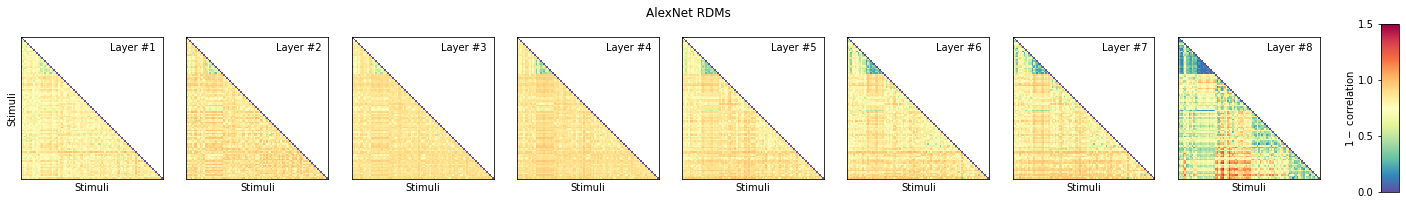

In [76]:
# Compute RDMs from the activations of each AlexNet layer
alexnet_rdms = activations_to_rdm(alexnet_dir, n_layers=8)
plot_rdms(alexnet_rdms, title='AlexNet RDMs', labels=layer_labels(8),
          file=figures_dir / 'rdms_alexnet.svg')

### 2.3 ResNet-18

In [14]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [15]:
class ResNet18(nn.Module):
  def __init__(self, output_layers, *args):
        super().__init__(*args)
        self.output_layers = output_layers
        #print(self.output_layers)
        self.selected_out = OrderedDict()
        #PRETRAINED MODEL
        self.pretrained = resnet18
        #self.pretrained = torchvision.....
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))
  def forward_hook(self,layer_name):
    def hook(module, input, output):
      self.selected_out[layer_name] = output
    return hook

  def forward(self, x):
    out = self.pretrained(x)
    return out, self.selected_out

In [16]:
model = ResNet18(output_layers = [0,1,2,3,4,5,6,7,8,9])

In [17]:
#@title Redefine function to extract activations
def get_activations_and_save(model, image_list, activations_dir):
  
  resize_normalize = trn.Compose([
            trn.Resize((224,224)),       # Resize the image to 224×224 pixels
            trn.ToTensor(),              # Convert the image to PyTorch Tensor data type
            trn.Normalize(               # Mean and std of image as also used when training the network
                [0.485, 0.456, 0.406], 
                [0.229, 0.224, 0.225])
            ])

  # for all images in the list generate and save activations
  for image_file in tqdm(image_list):
    # open image
    img = Image.open(image_file)
    image_file_name = os.path.split(image_file)[-1].split(".")[0]

    # apply transformations before feeding to model
    input_img = V(resize_normalize(img).unsqueeze(0))
    if torch.cuda.is_available():
      input_img=input_img.cuda()
    [out,x] = model(input_img)


    activations = []
    for i,feat in enumerate(x):
      activations.append(x[feat].data.cpu().numpy().ravel())

    for layer in range(len(activations)):
      save_path = os.path.join(activations_dir, image_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
      np.save(save_path,activations[layer])

In [18]:
# Set saving directory for ResNet18 activations
ResNet18_dir = activations_dir / 'activations_ResNet18'

######### get and save activations ################################
if not os.path.exists(ResNet18_dir):
    os.makedirs(ResNet18_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, image_list, ResNet18_dir)
###################################################################

  0%|          | 0/92 [00:00<?, ?it/s]

-------------Saving activations ----------------------------


100%|██████████| 92/92 [04:15<00:00,  2.78s/it]


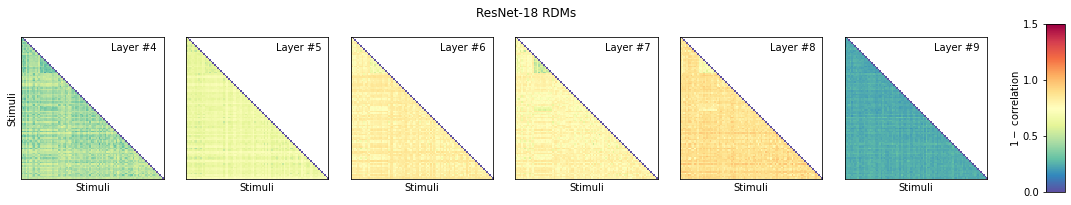

In [77]:
# Compute RDMs from the activations of each ResNet layer
resnet18_rdms = activations_to_rdm(ResNet18_dir, n_layers=10)

# Select only the relevant ResNet layers
relevant_resnet_layers = np.array([4, 5, 6, 7, 8, 9])
resnet_idxs = relevant_resnet_layers - 1
resnet18_rdms = resnet18_rdms[resnet_idxs]

# Plot RDMs
resnet_labels = [f'Layer #{x}' for x in relevant_resnet_layers]
plot_rdms(resnet18_rdms, title='ResNet-18 RDMs',
          labels=resnet_labels,
          file=figures_dir / 'rdms_resnet18.svg')

In [31]:
resnet18_rdms = backup

### 2.4 ResNet-50

In [43]:
resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [44]:
class ResNet50(nn.Module):
  def __init__(self, output_layers, *args):
        super().__init__(*args)
        self.output_layers = output_layers
        #print(self.output_layers)
        self.selected_out = OrderedDict()
        #PRETRAINED MODEL
        self.pretrained = resnet50
        #self.pretrained = torchvision.....
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))
  def forward_hook(self,layer_name):
    def hook(module, input, output):
      self.selected_out[layer_name] = output
    return hook

  def forward(self, x):
    out = self.pretrained(x)
    return out, self.selected_out

In [45]:
model = ResNet50(output_layers = [0,1,2,3,4,5,6,7,8,9])

In [46]:
# Set saving directory for ResNet50 activations
ResNet50_dir = activations_dir / 'activations_ResNet50'

######### get and save activations ################################
if not os.path.exists(ResNet50_dir):
    os.makedirs(ResNet50_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, image_list, ResNet50_dir)
###################################################################

  0%|          | 0/92 [00:00<?, ?it/s]

-------------Saving activations ----------------------------


100%|██████████| 92/92 [04:44<00:00,  3.09s/it]


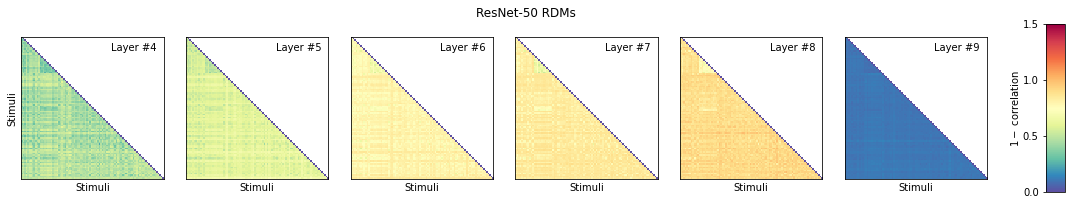

In [78]:
# Compute RDMs from the activations of each ResNet50 layer
ResNet50_rdms = activations_to_rdm(ResNet50_dir, n_layers=10)
ResNet50_rdms = ResNet50_rdms[resnet_idxs]
plot_rdms(ResNet50_rdms, title='ResNet-50 RDMs',
          labels=resnet_labels,
          file=figures_dir / 'rdms_resnet50.svg')

### 2.5 ResNet101

In [50]:
resnet101 = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


In [51]:
class ResNet101(nn.Module):
  def __init__(self, output_layers, *args):
        super().__init__(*args)
        self.output_layers = output_layers
        #print(self.output_layers)
        self.selected_out = OrderedDict()
        #PRETRAINED MODEL
        self.pretrained = resnet101
        #self.pretrained = torchvision.....
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))
  def forward_hook(self,layer_name):
    def hook(module, input, output):
      self.selected_out[layer_name] = output
    return hook

  def forward(self, x):
    out = self.pretrained(x)
    return out, self.selected_out

In [52]:
model = ResNet101(output_layers = [0,1,2,3,4,5,6,7,8,9])

In [53]:
def get_activations_and_save(model, image_list, activations_dir):
  
  resize_normalize = trn.Compose([
            trn.Resize((224,224)),       # Resize the image to 224×224 pixels
            trn.ToTensor(),              # Convert the image to PyTorch Tensor data type
            trn.Normalize(               # Mean and std of image as also used when training the network
                [0.485, 0.456, 0.406], 
                [0.229, 0.224, 0.225])
            ])

  # for all images in the list generate and save activations
  for image_file in tqdm(image_list):
    # open image
    img = Image.open(image_file)
    image_file_name = os.path.split(image_file)[-1].split(".")[0]

    # apply transformations before feeding to model
    input_img = V(resize_normalize(img).unsqueeze(0))
    if torch.cuda.is_available():
      input_img=input_img.cuda()
    [out,x] = model(input_img)


    activations = []
    for i,feat in enumerate(x):
      activations.append(x[feat].data.cpu().numpy().ravel())

    for layer in range(len(activations)):
      save_path = os.path.join(activations_dir, image_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
      np.save(save_path,activations[layer])

In [54]:
# Set saving directory for ResNet50 activations
ResNet101_dir = activations_dir / 'activations_ResNet101'

######### get and save activations ################################
if not os.path.exists(ResNet101_dir):
    os.makedirs(ResNet101_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, image_list, ResNet101_dir)
###################################################################

  0%|          | 0/92 [00:00<?, ?it/s]

-------------Saving activations ----------------------------


100%|██████████| 92/92 [01:06<00:00,  1.39it/s]


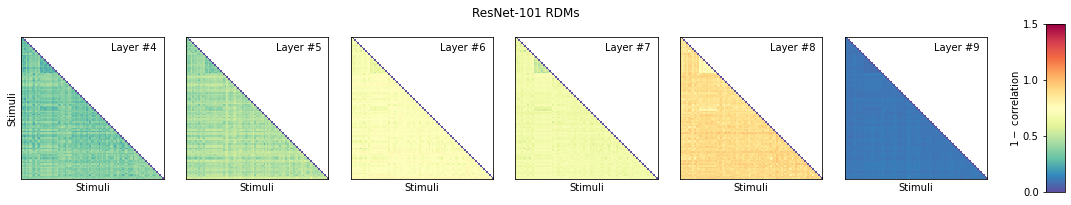

In [79]:
# Compute RDMs from the activations of each ResNet101 layer
ResNet101_rdms = activations_to_rdm(ResNet101_dir, n_layers=10)
ResNet101_rdms = ResNet101_rdms[resnet_idxs]
plot_rdms(ResNet101_rdms, title='ResNet-101 RDMs',
          labels=resnet_labels,
          file=figures_dir / 'rdms_resnet101.svg')

### 2.6 ResNet 152

In [56]:
resnet152 = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


In [57]:
class ResNet152(nn.Module):
  def __init__(self, output_layers, *args):
        super().__init__(*args)
        self.output_layers = output_layers
        #print(self.output_layers)
        self.selected_out = OrderedDict()
        #PRETRAINED MODEL
        self.pretrained = resnet152
        #self.pretrained = torchvision.....
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))
  def forward_hook(self,layer_name):
    def hook(module, input, output):
      self.selected_out[layer_name] = output
    return hook

  def forward(self, x):
    out = self.pretrained(x)
    return out, self.selected_out

In [58]:
model = ResNet152(output_layers = [0,1,2,3,4,5,6,7,8,9])

In [59]:
# Set saving directory for ResNet50 activations
ResNet152_dir = activations_dir / 'activations_ResNet152'

######### get and save activations ################################
if not os.path.exists(ResNet152_dir):
    os.makedirs(ResNet152_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, image_list, ResNet152_dir)
###################################################################

  0%|          | 0/92 [00:00<?, ?it/s]

-------------Saving activations ----------------------------


100%|██████████| 92/92 [01:18<00:00,  1.18it/s]


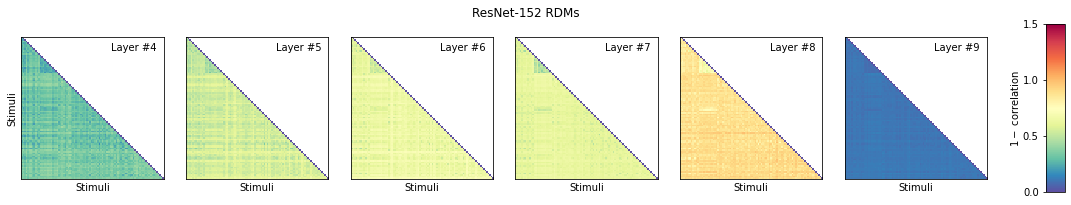

In [80]:
# Compute RDMs from the activations of each ResNet152 layer
ResNet152_rdms = activations_to_rdm(ResNet152_dir, n_layers=10)
ResNet152_rdms = ResNet152_rdms[resnet_idxs]
plot_rdms(ResNet152_rdms, title='ResNet-152 RDMs',
          labels=resnet_labels,
          file=figures_dir / 'rdms_resnet152.svg')

### 2.5 MoCo

In [62]:
## cd directory so as to import utils 
os.chdir('/content/drive/Shareddrives/NMA-Computational Neuroscience')

In [63]:
# import modules for MoCo
import argparse
import torchvision.transforms as transforms
import torchvision.models as models
from torch import Tensor
from collections import OrderedDict 
from utils.MoCoConstruction import main_worker 
import numpy as np


In [64]:
#@title define the pretrained MoCo
def get_MoCo():
  from datetime import datetime
  import warnings
  import torch.multiprocessing as mp
    
  model_names = sorted(name for name in models.__dict__
  if name.islower() and not name.startswith("__")
  and callable(models.__dict__[name]))

  parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
  parser.add_argument('-a', '--arch', metavar='ARCH', default='resnet50',
                    choices=model_names,
                    help='model architecture: ' +
                        ' | '.join(model_names) +
                        ' (default: resnet50)')
  parser.add_argument('-j', '--workers', default=32, type=int, metavar='N',
                    help='number of data loading workers (default: 32)')
  parser.add_argument('--epochs', default=200, type=int, metavar='N',
                    help='number of total epochs to run')
  parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
  parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
  parser.add_argument('--lr', '--learning-rate', default=0.03, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
  parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int,
                    help='learning rate schedule (when to drop lr by 10x)')
  parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum of SGD solver')
  parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
  parser.add_argument('-p', '--print-freq', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
  parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
  parser.add_argument('--world-size', default=-1, type=int,
                    help='number of nodes for distributed training')
  parser.add_argument('--rank', default=-1, type=int,
                    help='node rank for distributed training')
  parser.add_argument('--dist-url', default='tcp://224.66.41.62:23456', type=str,
                    help='url used to set up distributed training')
  parser.add_argument('--dist-backend', default='nccl', type=str,
                    help='distributed backend')
  parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
  parser.add_argument('--gpu', default=None, type=int,
                    help='GPU id to use.')
  parser.add_argument('--multiprocessing-distributed', action='store_true',
                    help='Use multi-processing distributed training to launch '
                         'N processes per node, which has N GPUs. This is the '
                         'fastest way to use PyTorch for either single node or '
                         'multi node data parallel training')

  # moco specific configs:
  parser.add_argument('--moco-dim', default=128, type=int,
                    help='feature dimension (default: 128)')
  parser.add_argument('--moco-k', default=65536, type=int,
                    help='queue size; number of negative keys (default: 65536)')
  parser.add_argument('--moco-m', default=0.999, type=float,
                    help='moco momentum of updating key encoder (default: 0.999)')
  parser.add_argument('--moco-t', default=0.07, type=float,
                    help='softmax temperature (default: 0.07)')

  # options for moco v2
  parser.add_argument('--mlp', action='store_true',
                    help='use mlp head')
  parser.add_argument('--aug-plus', action='store_true',
                    help='use moco v2 data augmentation')
  parser.add_argument('--cos', action='store_true',
                    help='use cosine lr schedule')
                    
  parser.add_argument('--results-dir', default='', type=str, metavar='PATH', help='path to cache (default: none)')                    
                    
  args = parser.parse_args('')

  # set command line arguments here when running in ipynb
  args.epochs = 200
  args.cos = True
  args.schedule = []  # cos in use
  args.symmetric = False
  args.start_epoch = 0
  #args.resume = 'moco_v1_200ep_pretrain.pth'
  #args.gpu = 0
  if args.results_dir == '':
    args.results_dir = './cache-' + datetime.now().strftime("%Y-%m-%d-%H-%M-%S-moco")

  print(args)

  if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    cudnn.deterministic = True
    warnings.warn('You have chosen to seed training. '
            'This will turn on the CUDNN deterministic setting, '
             'which can slow down your training considerably! '
            'You may see unexpected behavior when restarting '
            'from checkpoints.')

  if args.gpu is not None:
    warnings.warn('You have chosen a specific GPU. This will completely '
              'disable data parallelism.')

  if args.dist_url == "env://" and args.world_size == -1:
    args.world_size = int(os.environ["WORLD_SIZE"])

  args.distributed = args.world_size > 1 or args.multiprocessing_distributed

  ngpus_per_node = torch.cuda.device_count()
  if args.multiprocessing_distributed:
    args.world_size = ngpus_per_node * args.world_size
    mp.spawn(main_worker, nprocs=ngpus_per_node, args=(ngpus_per_node, args))
  else:
    WholeModel = main_worker(args.gpu, ngpus_per_node, args)
    
  if not os.path.exists('moco_v2_800ep_pretrain.pth'):
    #os.system('wget -O moco_v1_200ep_pretrain.pth --no-check-certificate -nc https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v1_200ep/moco_v1_200ep_pretrain.pth.tar') 
    os.system('wget -O moco_v2_800ep_pretrain.pth --no-check-certificate -nc https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar') 
  newmodel =WholeModel.encoder_q
  checkpoint = torch.load('moco_v2_800ep_pretrain.pth')
  # rename moco pre-trained keys
  state_dict = checkpoint['state_dict']
  for k in list(state_dict.keys()):
    # retain only encoder_q up to before the embedding layer
    if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
      # remove prefix
      state_dict[k[len("module.encoder_q."):]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
        
  msg = newmodel.load_state_dict(state_dict, strict=False)
  assert set(msg.missing_keys) == {"fc.weight", "fc.bias"} 
  print("=> loaded pre-trained model '{}'".format('moco_v2_800ep_pretrain.pth'))
    
  model = []
  for name, module in newmodel.named_children():
    if isinstance(module, nn.Linear):
      
      model.append(nn.Flatten(1))
    model.append(module)

  model = nn.Sequential(*model)
        
  return model

In [65]:
# using the forward hook for getting feature activation
class MoCoModel(nn.Module):
  def __init__(self, output_layers, *args):
        super().__init__(*args)
        self.output_layers = output_layers
        #print(self.output_layers)
        self.selected_out = OrderedDict()
        #PRETRAINED MODEL
        self.pretrained = get_MoCo()
        #self.pretrained = torchvision.....
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))
  def forward_hook(self,layer_name):
    def hook(module, input, output):
      self.selected_out[layer_name] = output
    return hook

  def forward(self, x):
    out = self.pretrained(x)
    return out, self.selected_out

In [66]:
# getting the model with forward hook
model = MoCoModel(output_layers = [0,1,2,3,4,5,6,7,8,9,10])

Namespace(arch='resnet50', aug_plus=False, batch_size=256, cos=True, dist_backend='nccl', dist_url='tcp://224.66.41.62:23456', epochs=200, gpu=None, lr=0.03, mlp=False, moco_dim=128, moco_k=65536, moco_m=0.999, moco_t=0.07, momentum=0.9, multiprocessing_distributed=False, print_freq=10, rank=-1, results_dir='./cache-2021-07-22-14-50-24-moco', resume='', schedule=[], seed=None, start_epoch=0, symmetric=False, weight_decay=0.0001, workers=32, world_size=-1)
=> creating model 'resnet50'
=> loaded pre-trained model 'moco_v2_800ep_pretrain.pth'


In [67]:
moco_dir = "/content/drive/Shareddrives/NMA-Computational Neuroscience/data/activations/mocoV2"
######### get and save activations ################################
if not os.path.exists(moco_dir):
    os.makedirs(moco_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, image_list, moco_dir)

  0%|          | 0/92 [00:00<?, ?it/s]

-------------Saving activations ----------------------------


100%|██████████| 92/92 [05:46<00:00,  3.77s/it]


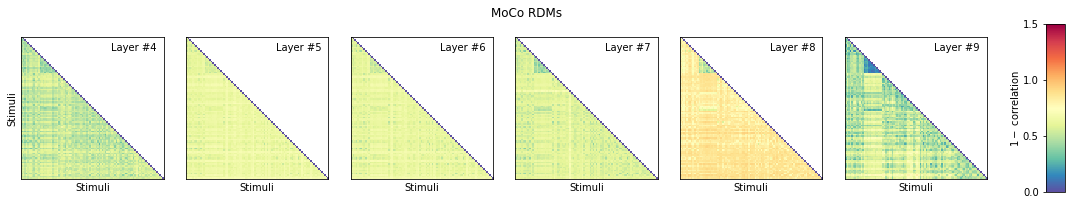

In [85]:
# Compute RDMs from the activations of each MoCo layer
moco_rdms = activations_to_rdm(moco_dir, n_layers=10)
moco_rdms = moco_rdms[resnet_idxs]
plot_rdms(moco_rdms, title='MoCo RDMs',
          labels=resnet_labels,
          file=figures_dir / 'rdms_moco.svg')

## 3. Compute representational similarity

### 3.1 Helper functions

In [119]:
#@title Define functions for correlating an fMRI RDM with network layer RDMs { display-mode: "form" }
def rdm_to_vector(rdm):
    """Extracts the lower triangle of an RDM in vector form.
    Parameters
    ----------
    rdm : np.array
        An RDM of shape (images x images)
    Returns
    -------
    rdm_vector : np.array
        A vector containing the lower triangular elements of the RDM
    """

    # Get lower triangle without the diagonal
    triu_idxs = np.triu_indices(rdm.shape[0], k=1)
    rdm_vector = rdm[triu_idxs]
    return(rdm_vector)


def resample_subjects_images(model_rdms, subject_rdms):
    """Creates new RDMs by resampling subjects and images with replacement
    Parameters
    ----------
    model_rdms : np.array
        The model RDMs with shape (layers x images x images)
    subject_rdms : np.array
        The empirical RDMs with shape (subjects x images x images)
    Returns
    -------
    model_rdms_bs : np.array
        The resampled model RDMs with shape (layers x images x images)
    subject_rdm_bs : np.array
        The resampled and averaged empirical RDM with shape (images x images)
    """

    # Sample new subejcts and images with replacement
    n_subjects, n_items, _ = subject_rdms.shape
    subject_idxs = np.random.choice(n_subjects, n_subjects, replace=True)
    item_idxs = np.random.choice(n_items, n_items, replace=True)

    # New model RDMs
    model_rdms_bs = model_rdms[:, item_idxs][:, :, item_idxs]

    # New (averaged) subject RDM
    subject_rdms_bs = subject_rdms[subject_idxs][:, item_idxs][:, :, item_idxs]
    subject_rdm_bs = subject_rdms_bs.mean(axis=0)

    return model_rdms_bs, subject_rdm_bs


def r_per_layer(X_rdms, y_rdm):
    """Computes correlation between an outcome RDM and each predictor RDM
    Parameters
    ----------
    X_rdms : np.array
        The predictor RDMs with shape (layers x images x images)
    y_rdm : np.array
        The outcome RDM with shape (images x images)
    Returns
    -------
    rs : np.array
        Spearman correlations with shape (layers)
    """

    # Transform to lower-triangular vectors
    X_vecs = [rdm_to_vector(X_rdm) for X_rdm in X_rdms]
    y_vec = rdm_to_vector(y_rdm)

    # Spearman's correlation
    rs = [spearmanr(X_vec, y_vec)[0] for X_vec in X_vecs]

    return rs


def bootstrap_rs(model_rdms, subject_rdms, n_bootstraps=1000):
    """Computes brain-model correlations while bootstrapping subjects and images
    Parameters
    ----------
    model_rdms : np.array
        The model RDMs with shape (layers x images x images)
    subject_rdms : np.array
        The empirical RDMs with shape (subjects x images x images)
    Returns
    -------
    bootstrap_rs : np.array
        Spearman correlations with shape (bootstraps x layers)
    """

    # Prepare empty array
    n_layers = model_rdms.shape[0]
    bootstrap_rs = np.zeros((n_bootstraps, n_layers))

    # Compute layer correlations at each bootstrap sample
    for i in range(n_bootstraps):
      X_rdms, y_rdm = resample_subjects_images(model_rdms, subject_rdms)
      bootstrap_rs[i, :] = r_per_layer(X_rdms, y_rdm)

    return bootstrap_rs


help(bootstrap_rs)

Help on function bootstrap_rs in module __main__:

bootstrap_rs(model_rdms, subject_rdms, n_bootstraps=1000)
    Computes brain-model correlations while bootstrapping subjects and images
    Parameters
    ----------
    model_rdms : np.array
        The model RDMs with shape (layers x images x images)
    subject_rdms : np.array
        The empirical RDMs with shape (subjects x images x images)
    Returns
    -------
    bootstrap_rs : np.array
        Spearman correlations with shape (bootstraps x layers)



In [120]:
#@title Define functions for computing total variance explained
def all_layers_r2_aic(X_rdms, y_rdm):
    """Computes explained variance in the outcome RDM by all predictor RDMs
    Parameters
    ----------
    X_rdms : np.array
        The predictor RDMs with shape (layers x images x images)
    y_rdm : np.array
        The outcome RDM with shape (images x images)
    Returns
    -------
    r2 : float
        Variance explained 
    aic : float
        Akaike Information Criterion
    """

    # Transform to lower-triangular vectors
    X = [rdm_to_vector(X_rdm) for X_rdm in X_rdms]
    X = np.array(X).T
    y = rdm_to_vector(y_rdm)
    y = y.reshape(-1, 1)

    # Standardize so we don't have to model the intercept
    X = StandardScaler().fit_transform(X)
    y = StandardScaler().fit_transform(y)

    # Fit regression model
    reg = linear_model.LinearRegression(fit_intercept=False)
    reg.fit(X, y)

    # Compute total variance explained
    r2 = reg.score(X, y)

    # Compute AIC
    y_hat = reg.predict(X)
    resid = y - y_hat
    sse = np.sum(resid ** 2)
    k = X.shape[1]
    aic = 2 * k - 2 * np.log(sse)
    return (r2, aic)


def bootstrap_r2s_aics(model_rdms, subject_rdms, n_bootstraps=1000):
    """Computes variance explained (+ AIC) by the whole DNN with bootstrapping
    Parameters
    ----------
    model_rdms : np.array
        The model RDMs with shape (layers x images x images)
    subject_rdms : np.array
        The empirical RDMs with shape (subjects x images x images)
    Returns
    -------
    bootstrap_r2s : np.array
        Variance explained with shape (bootstraps)
    bootstrap_aics : np.array
        Akaike Information Criterion with shape (bootstrap)
    """

    # Prepare empty array
    bootstrap_r2s = np.zeros(n_bootstraps)
    bootstrap_aics = np.zeros(n_bootstraps)

    # Compute variance explained and AIC for all bootstrap samples
    for i in range(n_bootstraps):
      X_rdms, y_rdm = resample_subjects_images(model_rdms, subject_rdms)
      res = all_layers_r2_aic(X_rdms, y_rdm)
      bootstrap_r2s[i] = res[0]
      bootstrap_aics[i] = res[1]
    
    return (bootstrap_r2s, bootstrap_aics)


help(bootstrap_r2s_aics)

Help on function bootstrap_r2s_aics in module __main__:

bootstrap_r2s_aics(model_rdms, subject_rdms, n_bootstraps=1000)
    Computes variance explained (+ AIC) by the whole DNN with bootstrapping
    Parameters
    ----------
    model_rdms : np.array
        The model RDMs with shape (layers x images x images)
    subject_rdms : np.array
        The empirical RDMs with shape (subjects x images x images)
    Returns
    -------
    bootstrap_r2s : np.array
        Variance explained with shape (bootstraps)
    bootstrap_aics : np.array
        Akaike Information Criterion with shape (bootstrap)



In [121]:
#@title Define functions for computing variance explained per layer
def r2_per_layer(X_rdms, y_rdm):
    """Computes explained variance in the outcome RDM by each predictor RDM
    Parameters
    ----------
    X_rdms : np.array
        The predictor RDMs with shape (layers x images x images)
    y_rdm : np.array
        The outcome RDM with shape (images x images)
    Returns
    -------
    r2s : np.array
        Variance explained with shape (layers)
    """

    # Transform to lower-triangular vectors
    X = [rdm_to_vector(X_rdm) for X_rdm in X_rdms]
    X = np.array(X).T
    y = rdm_to_vector(y_rdm)
    y = y.reshape(-1, 1)

    # Standardize so we don't have to model the intercept
    X = StandardScaler().fit_transform(X)
    y = StandardScaler().fit_transform(y)

    # Fit full regression model
    reg = linear_model.LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    r2 = reg.score(X, y)

    # Compute delta R^2s by dropping every layer once
    delta_r2s = np.array([])
    n_layers = X.shape[1]
    for layer_ix in range(n_layers):
      X_drop = np.delete(X, layer_ix, axis=1)
      reg.fit(X_drop, y)
      r2_drop = reg.score(X_drop, y)
      delta_r2s = np.append(delta_r2s, r2 - r2_drop)

    return delta_r2s


def bootstrap_r2s_layers(model_rdms, subject_rdms, n_bootstraps=1000):
    """Computes brain variance explained by each model RDM with bootstrapping 
    Parameters
    ----------
    model_rdms : np.array
        The model RDMs with shape (layers x images x images)
    subject_rdms : np.array
        The empirical RDMs with shape (subjects x images x images)
    Returns
    -------
    bootstrap_r2s : np.array
        Variance explained with shape (bootstraps x layers)
    """

    # Prepare empty array
    n_layers = model_rdms.shape[0]
    bootstrap_r2s = np.zeros((n_bootstraps, n_layers))
    bootstrap_aics = np.zeros((n_bootstraps, n_layers))

    # Compute variance explained per layer for all bootstrap samples
    for i in range(n_bootstraps):
      X_rdms, y_rdm = resample_subjects_images(model_rdms, subject_rdms)
      bootstrap_r2s[i, :] = r2_per_layer(X_rdms, y_rdm)
    
    return bootstrap_r2s


help(bootstrap_r2s_layers)

Help on function bootstrap_r2s_layers in module __main__:

bootstrap_r2s_layers(model_rdms, subject_rdms, n_bootstraps=1000)
    Computes brain variance explained by each model RDM with bootstrapping 
    Parameters
    ----------
    model_rdms : np.array
        The model RDMs with shape (layers x images x images)
    subject_rdms : np.array
        The empirical RDMs with shape (subjects x images x images)
    Returns
    -------
    bootstrap_r2s : np.array
        Variance explained with shape (bootstraps x layers)



In [156]:
#@title Define plotting functions { display-mode: "form" }
def lineplot(evc_scores, it_scores, r2=False, title=None, file=None):
    """Line plot for fMRI correlations or variance explained per layer.
    Parameters
    ----------
    evc_scores : np.array
        EVC-model correlations (or R^2s) with shape (bootstrap samples x layers)
    it_scores : np.array
        IT-model correlations (or R^2s) with shape (bootstrap samples x layers)
    r2 : bool
        If True, label y-axis as delta R^2 instead of correlation
    title : str
        Optional plot title
    file : str or Path-like
        Optional file name to save
    """

    # Prepare figure
    color_evc, color_it = sns.color_palette('Set1', n_colors=2)
    plt.figure(figsize=(3, 3))

    # Plot all bootstrap samples
    layers = range(1, evc_scores.shape[1] + 1)
    plt.plot(layers, evc_scores.T, alpha=0.005, color=color_evc)
    plt.plot(layers, it_scores.T, alpha=0.005, color=color_it)

    # Plot mean over bootstrap samples
    plt.plot(layers, evc_scores.mean(axis=0), color=color_evc,
            label='EVC', linewidth=3)
    plt.plot(layers, it_scores.mean(axis=0), color=color_it,
            label='IT', linewidth=3)

    # Beautify
    plt.legend(frameon=False)
    plt.xticks(layers)
    plt.xlabel('Layer')
    plt.xlim((1, max(layers)))
    plt.ylim((0, 0.1))
    if not r2:
      plt.ylabel('Spearman\'s $r$')
      plt.ylim((-0.2, 0.8))
      plt.axhline(y=0, color='black', linestyle='dotted')
    else:
      plt.ylabel('$\Delta R^2$')
      plt.ylim((0, 0.1))

    # Add title
    if title is not None:
      plt.title(title)

    # Save if requested
    if file is not None:
      plt.savefig(file, dpi=1000)


help(lineplot)

Help on function lineplot in module __main__:

lineplot(evc_scores, it_scores, r2=False, title=None, file=None)
    Line plot for fMRI correlations or variance explained per layer.
    Parameters
    ----------
    evc_scores : np.array
        EVC-model correlations (or R^2s) with shape (bootstrap samples x layers)
    it_scores : np.array
        IT-model correlations (or R^2s) with shape (bootstrap samples x layers)
    r2 : bool
        If True, label y-axis as delta R^2 instead of correlation
    title : str
        Optional plot title
    file : str or Path-like
        Optional file name to save



In [157]:
# Number of bootstrap samples. Decrease if you're pressed on time
n_bootstraps = 1000

### 3.2 AlexNet

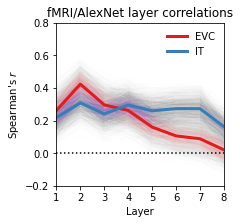

In [158]:
# Compute bootstrapped correlations between fMRI and each AlexNet layer
rs_alexnet_evc = bootstrap_rs(alexnet_rdms, evc_rdms, n_bootstraps)
rs_alexnet_it = bootstrap_rs(alexnet_rdms, it_rdms, n_bootstraps)

# Plot correlations
lineplot(rs_alexnet_evc, rs_alexnet_it,
         title='fMRI/AlexNet layer correlations',
         file = figures_dir / 'corrs_alexnet.svg')

In [159]:
# Compute total variance explained by AlexNet
evc_r2s, evc_aics = bootstrap_r2s_aics(alexnet_rdms, evc_rdms, n_bootstraps)

# Average across bootstrap samples
print(f'EVC variance explained by AlexNet: {evc_r2s.mean(axis=0)}')
print(f'AIC: {evc_aics.mean(axis=0)}')

EVC variance explained by AlexNet: 0.474256085778272
AIC: 0.6170564599664481


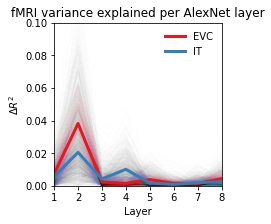

In [160]:
# Compute variance explained per AlexNet layer
evc_r2s_per_layer = bootstrap_r2s_layers(alexnet_rdms, evc_rdms, n_bootstraps)
it_r2s_per_layer = bootstrap_r2s_layers(alexnet_rdms, it_rdms, n_bootstraps)

# Plot variance explained per layer
lineplot(evc_r2s_per_layer, it_r2s_per_layer, r2=True,
         title='fMRI variance explained per AlexNet layer',
         file = figures_dir / 'r2s_alexnet.svg')

### 3.3 ResNet-18

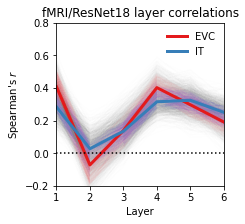

In [161]:
# Compute bootstrapped correlations between fMRI and each AlexNet layer
rs_ResNet18_evc = bootstrap_rs(resnet18_rdms, evc_rdms, n_bootstraps)
rs_ResNet18_it = bootstrap_rs(resnet18_rdms, it_rdms, n_bootstraps)

# Plot correlations
lineplot(rs_ResNet18_evc, rs_ResNet18_it,
         title='fMRI/ResNet18 layer correlations',
         file = figures_dir / 'corrs_resnet18.svg')

In [162]:
# Compute total variance explained by ResNet18
evc_r2s, evc_aics = bootstrap_r2s_aics(resnet18_rdms, evc_rdms, n_bootstraps)

# Average across bootstrap samples
print(f'EVC variance explained by ResNet18: {evc_r2s.mean(axis=0)}')
print(f'AIC: {evc_aics.mean(axis=0)}')

EVC variance explained by ResNet18: 0.5508803980499026
AIC: -3.0615537193829443


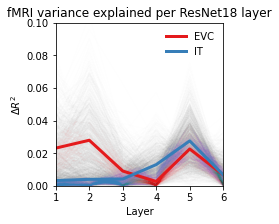

In [163]:
# Compute variance explained per ResNet18 layer
evc_r2s_per_layer = bootstrap_r2s_layers(resnet18_rdms, evc_rdms, n_bootstraps)
it_r2s_per_layer = bootstrap_r2s_layers(resnet18_rdms, it_rdms, n_bootstraps)

# Plot variance explained per layer
lineplot(evc_r2s_per_layer, it_r2s_per_layer, r2=True,
         title='fMRI variance explained per ResNet18 layer',
         file = figures_dir / 'r2s_resnet18.svg')

### 3.4 ResNet-50

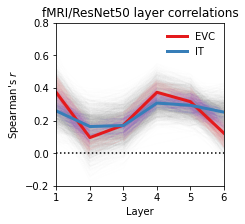

In [164]:
# Compute bootstrapped correlations between fMRI and each ResNet layer
rs_ResNet50_evc = bootstrap_rs(ResNet50_rdms, evc_rdms, n_bootstraps)
rs_ResNet50_it = bootstrap_rs(ResNet50_rdms, it_rdms, n_bootstraps)

# Plot correlations
lineplot(rs_ResNet50_evc, rs_ResNet50_it,
         title='fMRI/ResNet50 layer correlations',
         file = figures_dir / 'corrs_resnet50.svg')

In [165]:
# Compute total variance explained by ResNet50
evc_r2s, evc_aics = bootstrap_r2s_aics(ResNet50_rdms, evc_rdms, n_bootstraps)

# Average across bootstrap samples
print(f'EVC variance explained by ResNet50: {evc_r2s.mean(axis=0)}')
print(f'AIC: {evc_aics.mean(axis=0)}')

EVC variance explained by ResNet50: 0.5512059584646763
AIC: -3.0594966913226953


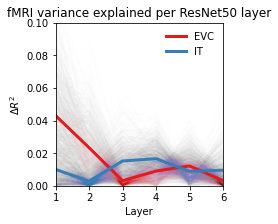

In [166]:
# Compute variance explained per ResNet50 layer
evc_r2s_per_layer = bootstrap_r2s_layers(ResNet50_rdms, evc_rdms, n_bootstraps)
it_r2s_per_layer = bootstrap_r2s_layers(ResNet50_rdms, it_rdms, n_bootstraps)

# Plot variance explained per layer
lineplot(evc_r2s_per_layer, it_r2s_per_layer, r2=True,
         title='fMRI variance explained per ResNet50 layer',
         file = figures_dir / 'r2s_resnet50.svg')

### 3.5 ResNet101


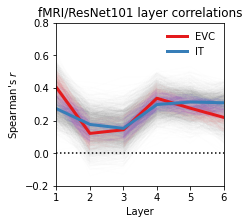

In [167]:
# Compute bootstrapped correlations between fMRI and each ResNet layer
rs_ResNet101_evc = bootstrap_rs(ResNet101_rdms, evc_rdms, n_bootstraps)
rs_ResNet101_it = bootstrap_rs(ResNet101_rdms, it_rdms, n_bootstraps)

# Plot correlations
lineplot(rs_ResNet101_evc, rs_ResNet101_it,
         title='fMRI/ResNet101 layer correlations',
         file = figures_dir / 'corrs_resnet101.svg')

In [168]:
# Compute total variance explained by ResNet101
evc_r2s, evc_aics = bootstrap_r2s_aics(ResNet101_rdms, evc_rdms, n_bootstraps)

# Average across bootstrap samples
print(f'EVC variance explained by ResNet101: {evc_r2s.mean(axis=0)}')
print(f'AIC: {evc_aics.mean(axis=0)}')

EVC variance explained by ResNet101: 0.5475796693983118
AIC: -3.0767949454288317


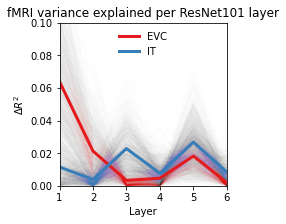

In [169]:
# Compute variance explained per ResNet101 layer
evc_r2s_per_layer = bootstrap_r2s_layers(ResNet101_rdms, evc_rdms, n_bootstraps)
it_r2s_per_layer = bootstrap_r2s_layers(ResNet101_rdms, it_rdms, n_bootstraps)

# Plot variance explained per layer
lineplot(evc_r2s_per_layer, it_r2s_per_layer, r2=True,
         title='fMRI variance explained per ResNet101 layer',
         file = figures_dir / 'r2s_resnet101.svg')

### 3.6 ResNet152


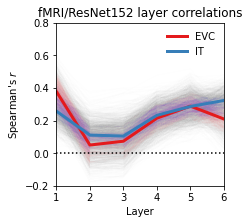

In [170]:
# Compute bootstrapped correlations between fMRI and each ResNet layer
rs_ResNet152_evc = bootstrap_rs(ResNet152_rdms, evc_rdms, n_bootstraps)
rs_ResNet152_it = bootstrap_rs(ResNet152_rdms, it_rdms, n_bootstraps)

# Plot correlations
lineplot(rs_ResNet152_evc, rs_ResNet152_it,
         title='fMRI/ResNet152 layer correlations',
         file = figures_dir / 'corrs_resnet152.svg')

In [171]:
# Compute total variance explained by ResNet152
evc_r2s, evc_aics = bootstrap_r2s_aics(ResNet152_rdms, evc_rdms, n_bootstraps)

# Average across bootstrap samples
print(f'EVC variance explained by ResNet152: {evc_r2s.mean(axis=0)}')
print(f'AIC: {evc_aics.mean(axis=0)}')

EVC variance explained by ResNet152: 0.5442017358776333
AIC: -3.0936200709694877


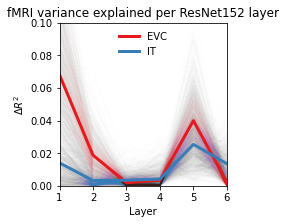

In [172]:
# Compute variance explained per ResNet101 layer
evc_r2s_per_layer = bootstrap_r2s_layers(ResNet152_rdms, evc_rdms, n_bootstraps)
it_r2s_per_layer = bootstrap_r2s_layers(ResNet152_rdms, it_rdms, n_bootstraps)

# Plot variance explained per layer
lineplot(evc_r2s_per_layer, it_r2s_per_layer, r2=True,
         title='fMRI variance explained per ResNet152 layer',
         file = figures_dir / 'r2s_resnet152.svg')

### 3.5 MoCo

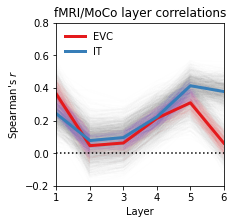

In [173]:
# Compute bootstrapped correlations between fMRI and each MoCo layer
rs_MoCo_evc = bootstrap_rs(moco_rdms, evc_rdms, n_bootstraps)
rs_MoCo_it = bootstrap_rs(moco_rdms, it_rdms, n_bootstraps)

# Plot correlations
lineplot(rs_MoCo_evc, rs_MoCo_it,
         title='fMRI/MoCo layer correlations',
         file = figures_dir / 'corrs_moco.svg')

In [174]:
# Compute total variance explained by MoCo
evc_r2s, evc_aics = bootstrap_r2s_aics(moco_rdms, evc_rdms, n_bootstraps)

# Average across bootstrap samples
print(f'EVC variance explained by MoCo: {evc_r2s.mean(axis=0)}')
print(f'AIC: {evc_aics.mean(axis=0)}')

EVC variance explained by MoCo: 0.5026091790928128
AIC: -3.269376350444679


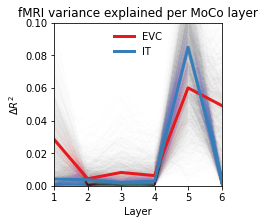

In [175]:
# Compute variance explained per MoCo layer
evc_r2s_per_layer = bootstrap_r2s_layers(moco_rdms, evc_rdms, n_bootstraps)
it_r2s_per_layer = bootstrap_r2s_layers(moco_rdms, it_rdms, n_bootstraps)

# Plot variance explained per layer
lineplot(evc_r2s_per_layer, it_r2s_per_layer, r2=True,
         title='fMRI variance explained per MoCo layer',
         file = figures_dir / 'r2s_moco.svg')

### 3.6 Overview

In [ ]:
# Get r2s of all networks
alex_evc_r2s, evc_aics = bootstrap_r2s_aics(alexnet_rdms, evc_rdms, n_bootstraps)
alex_it_r2s, it_aics = bootstrap_r2s_aics(alexnet_rdms, it_rdms, n_bootstraps)

res18_evc_r2s, evc_aics = bootstrap_r2s_aics(resnet18_rdms, evc_rdms, n_bootstraps)
res18_it_r2s, it_aics = bootstrap_r2s_aics(resnet18_rdms, it_rdms, n_bootstraps)

res50_evc_r2s, evc_aics = bootstrap_r2s_aics(ResNet50_rdms, evc_rdms, n_bootstraps)
res50_it_r2s, it_aics = bootstrap_r2s_aics(ResNet50_rdms, it_rdms, n_bootstraps)

res101_evc_r2s, evc_aics = bootstrap_r2s_aics(ResNet101_rdms, evc_rdms, n_bootstraps)
res101_it_r2s, it_aics = bootstrap_r2s_aics(ResNet101_rdms, it_rdms, n_bootstraps)

res152_evc_r2s, evc_aics = bootstrap_r2s_aics(ResNet152_rdms, evc_rdms, n_bootstraps)
res152_it_r2s, it_aics = bootstrap_r2s_aics(ResNet152_rdms, it_rdms, n_bootstraps)

moco_evc_r2s, evc_aics = bootstrap_r2s_aics(moco_rdms, evc_rdms, n_bootstraps)
moco_it_r2s, it_aics = bootstrap_r2s_aics(moco_rdms, it_rdms, n_bootstraps)

# Prep data for plotting
EVC = [alex_evc_r2s.mean(axis=0), res18_evc_r2s.mean(axis=0), res50_evc_r2s.mean(axis=0), res101_evc_r2s.mean(axis=0), res152_evc_r2s.mean(axis=0), moco_evc_r2s.mean(axis=0)]
IT = [alex_it_r2s.mean(axis=0), res18_it_r2s.mean(axis=0), res50_it_r2s.mean(axis=0), res101_it_r2s.mean(axis=0), res152_it_r2s.mean(axis=0), moco_it_r2s.mean(axis=0)]
EVC_error = [alex_evc_r2s.std(axis=0), res18_evc_r2s.std(axis=0), res50_evc_r2s.std(axis=0), res101_evc_r2s.std(axis=0), res152_evc_r2s.std(axis=0), moco_evc_r2s.std(axis=0)]
IT_error = [alex_it_r2s.std(axis=0), res18_it_r2s.std(axis=0), res50_it_r2s.std(axis=0), res101_it_r2s.std(axis=0), res152_it_r2s.std(axis=0), moco_it_r2s.std(axis=0)]

index = ['Alexnet', 'ResNet18', 'ResNet50', 'ResNet101', 'ResNet152', 'Moco']

df = pd.DataFrame({'EVC': EVC,
                   'IT': IT}, index=index)
df['EVC_error'] = EVC_error
df['IT_error'] = IT_error
color_evc, color_it = sns.color_palette('Set1', n_colors=2)

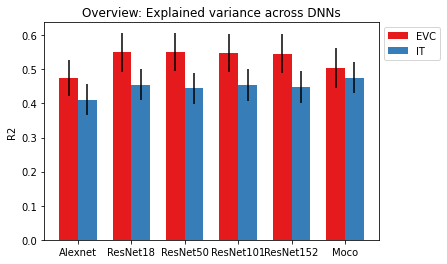

In [182]:
# Plotting

ind = np.arange(6)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(ind - width/2, EVC, width, yerr=EVC_error,
                label='EVC', color=color_evc)
rects2 = ax.bar(ind + width/2, IT, width, yerr=IT_error,
                label='IT', color=color_it)

ax.set_title('Overview: Explained variance across DNNs')

ax.set_xticks(ind)
ax.set_xticklabels(('Alexnet', 'ResNet18', 'ResNet50',
         'ResNet101', 'ResNet152', 'Moco'))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
ax.set_ylabel('R2')

plt.savefig(figures_dir / 'overview_r2s_dnns.svg', dpi=1000)